<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_1704_feature_extraction_01_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Feature Extraction Template

In [2]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


Classification Report (PCA):
              precision    recall  f1-score   support

           0       0.86      0.39      0.54      4673
           1       0.27      0.78      0.40      1327

    accuracy                           0.48      6000
   macro avg       0.56      0.58      0.47      6000
weighted avg       0.73      0.48      0.51      6000



/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_factor_analysis.py:297: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  warnings.warn(


Classification Report (Factor Analysis):
              precision    recall  f1-score   support

           0       0.86      0.39      0.53      4673
           1       0.27      0.78      0.40      1327

    accuracy                           0.47      6000
   macro avg       0.56      0.58      0.47      6000
weighted avg       0.73      0.47      0.50      6000

Classification Report (Target Encoding):
              precision    recall  f1-score   support

           0       0.87      0.39      0.54      4673
           1       0.27      0.80      0.40      1327

    accuracy                           0.48      6000
   macro avg       0.57      0.59      0.47      6000
weighted avg       0.74      0.48      0.51      6000

Classification Report (Polynomial Features):
              precision    recall  f1-score   support

           0       0.88      0.45      0.59      4673
           1       0.29      0.78      0.42      1327

    accuracy                           0.52      6000
 

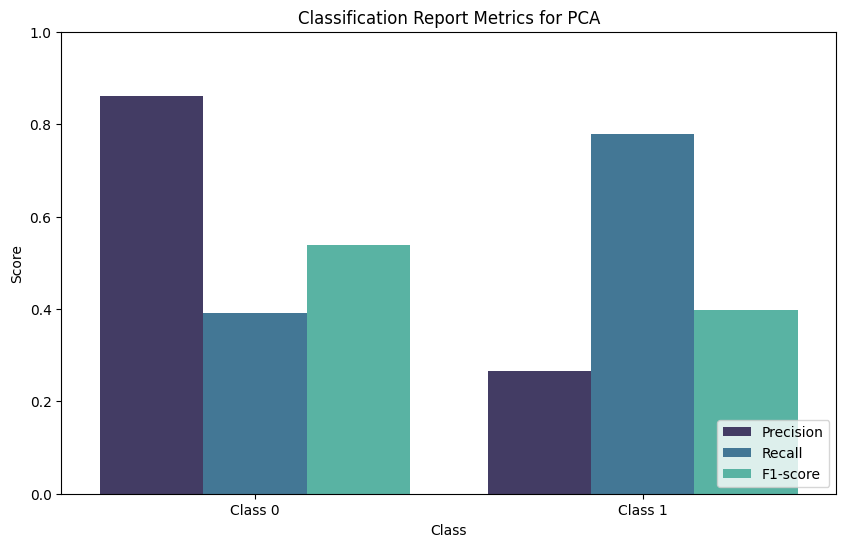

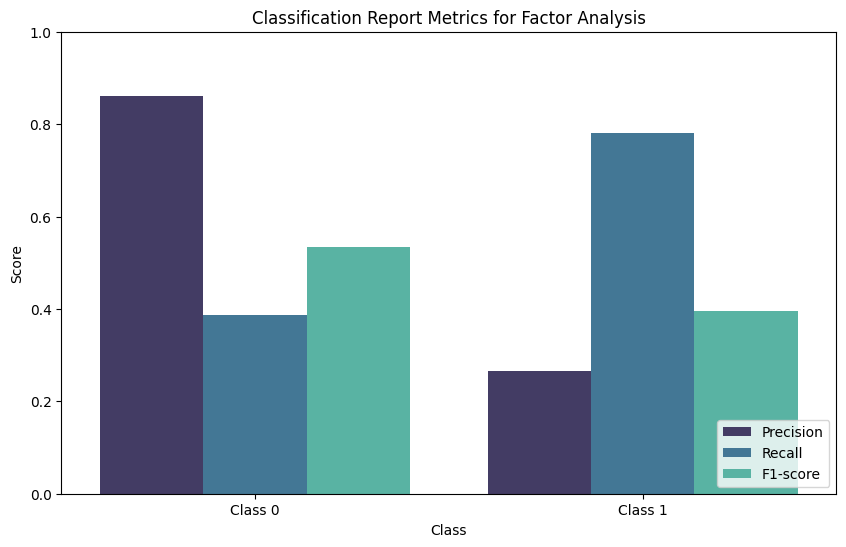

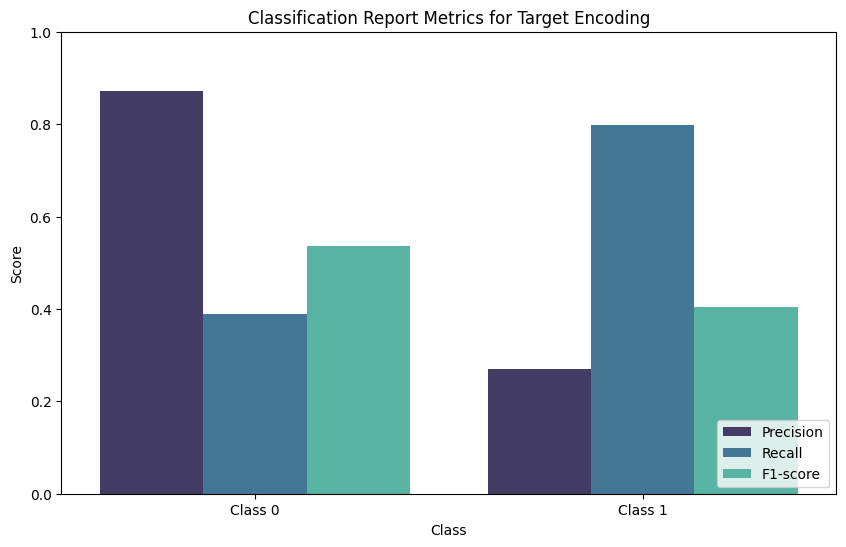

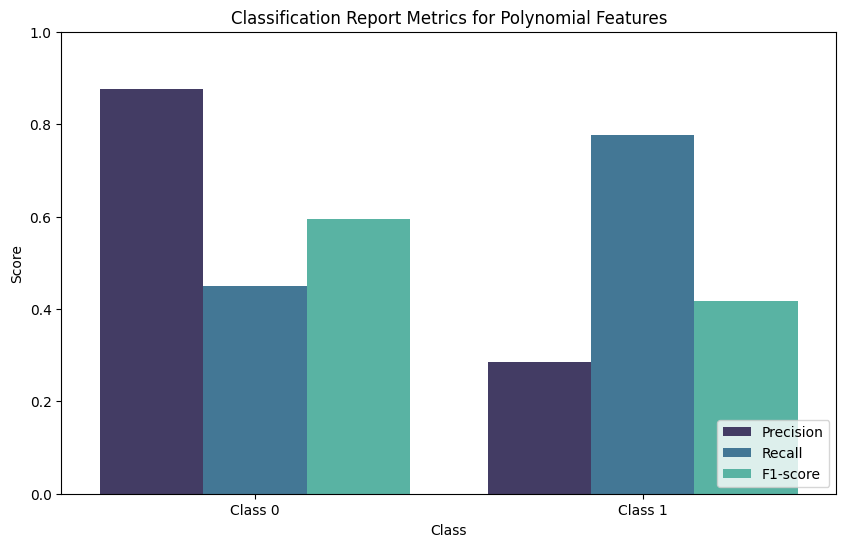

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA, FactorAnalysis
import json
import warnings
import category_encoders as ce
from loan_data_utils import load_and_preprocess_data

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define a custom classifier to handle class-specific threshold
class ThresholdClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, base_classifier, threshold=0.3):
        self.base_classifier = base_classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.base_classifier.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.base_classifier.predict_proba(X)

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= self.threshold).astype(int)

# Apply SMOTE and then the preprocessing pipeline
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Use the custom classifier with Logistic Regression and a threshold of 0.3 for class 1
base_classifier = LogisticRegression(max_iter=3000)
classifier = ThresholdClassifier(base_classifier, threshold=0.3)

# Initialize results dictionary
results = {}

# Principal Component Analysis (PCA)
preprocessor_pca = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=10))
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

pipeline_pca = Pipeline(steps=[
    ('preprocessor', preprocessor_pca),
    ('classifier', classifier)
])

pipeline_pca.fit(X_train_res, y_train_res)
y_pred_pca = pipeline_pca.predict(X_test)
print("Classification Report (PCA):")
print(classification_report(y_test, y_pred_pca))
classification_report_pca = classification_report(y_test, y_pred_pca, output_dict=True)

results['PCA'] = classification_report_pca

# Factor Analysis
preprocessor_fa = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('fa', FactorAnalysis(n_components=10))
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

pipeline_fa = Pipeline(steps=[
    ('preprocessor', preprocessor_fa),
    ('classifier', classifier)
])

pipeline_fa.fit(X_train_res, y_train_res)
y_pred_fa = pipeline_fa.predict(X_test)
print("Classification Report (Factor Analysis):")
print(classification_report(y_test, y_pred_fa))
classification_report_fa = classification_report(y_test, y_pred_fa, output_dict=True)

results['Factor Analysis'] = classification_report_fa

# Target Encoding
preprocessor_te = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('target_encoder', ce.TargetEncoder())
        ]), categorical_features)
    ])

pipeline_te = Pipeline(steps=[
    ('preprocessor', preprocessor_te),
    ('classifier', classifier)
])

pipeline_te.fit(X_train_res, y_train_res)
y_pred_te = pipeline_te.predict(X_test)
print("Classification Report (Target Encoding):")
print(classification_report(y_test, y_pred_te))
classification_report_te = classification_report(y_test, y_pred_te, output_dict=True)

results['Target Encoding'] = classification_report_te

# Polynomial Features
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2))
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', classifier)
])

pipeline_poly.fit(X_train_res, y_train_res)
y_pred_poly = pipeline_poly.predict(X_test)
print("Classification Report (Polynomial Features):")
print(classification_report(y_test, y_pred_poly))
classification_report_poly = classification_report(y_test, y_pred_poly, output_dict=True)

results['Polynomial Features'] = classification_report_poly

# Save the classification reports to a JSON file
with open('classification_reports.json', 'w') as f:
    json.dump(results, f, indent=4)

# Plotting function
def plot_classification_report_metrics(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()

# Load and plot metrics for feature selection methods
with open('classification_reports.json', 'r') as f:
    results = json.load(f)

for method, report in results.items():
    plot_classification_report_metrics(report, method)


### Data Utils Script

In [1]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import joblib
import json
import logging
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#--------   Load and Preprocess Data   --------#

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

#--------   Plot Class Distribution   --------#


def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

#--------   Plot Classification Report Metrics   --------#

def plot_classification_report_metrics(report, method_name, threshold):
    """
    Function to plot the precision, recall, and f1-score metrics for class 0 and class 1.
    """
    # Extract metrics from the report
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    # Plot the metrics
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {method_name} at Threshold {threshold}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()




#--------   Evaluate and Capture Metrics   --------#

# Function to evaluate model
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, experiment_name):
    logger.info(f"Training and evaluating model: {model_name} ({experiment_name})")

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Capture classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract relevant metrics
    metrics = {
        'Model': model_name,
        'Experiment': experiment_name,
        'Recall_0': report['0']['recall'],
        'Precision_0': report['0']['precision'],
        'F1_0': report['0']['f1-score'],
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'F1_Macro': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }
    return metrics


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *

Script successfully written to loan_data_utils.py
